<a href="https://colab.research.google.com/github/dorbsacos/Cali-Housing-RandomForestReg/blob/main/ML_model_Cali_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Converting our data into a Dataframe and performing EDA.
from sklearn.datasets import fetch_california_housing
import pandas as pd

data= fetch_california_housing() #Not a standard dict type in python, print(type(data)) gives class 'sklearn.utils.Bunch'.
df = pd.DataFrame(data.data, columns=data.feature_names) #As the data is a Bunch object(rather than dict), we need to specify the column names and corresponding row values to create a dataframe.
df["Target"] = data.target #Addition of new column to our data frame.

print(df.head()) #Gives first few rows in the dataframe

print(df.info()) # this gives no.of rows, column names, non null values etc..

print(df.describe()) # Gives the charectersitics such as mean, standard deviation etc for every column

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOc

Preprocessed DataFrame Head:
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  2.344766  0.982143  0.628559  -0.153758   -0.974429 -0.049597  1.052548   
1  2.332238 -0.607019  0.327041  -0.263336    0.861439 -0.092512  1.043185   
2  1.782699  1.856182  1.155620  -0.049016   -0.820777 -0.025843  1.038503   
3  0.932968  1.856182  0.156966  -0.049833   -0.766028 -0.050329  1.038503   
4 -0.012881  1.856182  0.344711  -0.032906   -0.759847 -0.085616  1.038503   

   Longitude  PopulationPerHousehold  RoomsPerPerson  Target  
0  -1.327835               -0.977033        0.227178   4.526  
1  -1.322844                1.669961       -0.110407   3.585  
2  -1.332827               -0.843637        0.139122   3.521  
3  -1.337818               -0.733781        0.027996   3.413  
4  -1.337818               -0.629157        0.040249   3.422   

Feature Correlation with Target:
Target                    1.000000
MedInc                    0.688075
AveRooms           

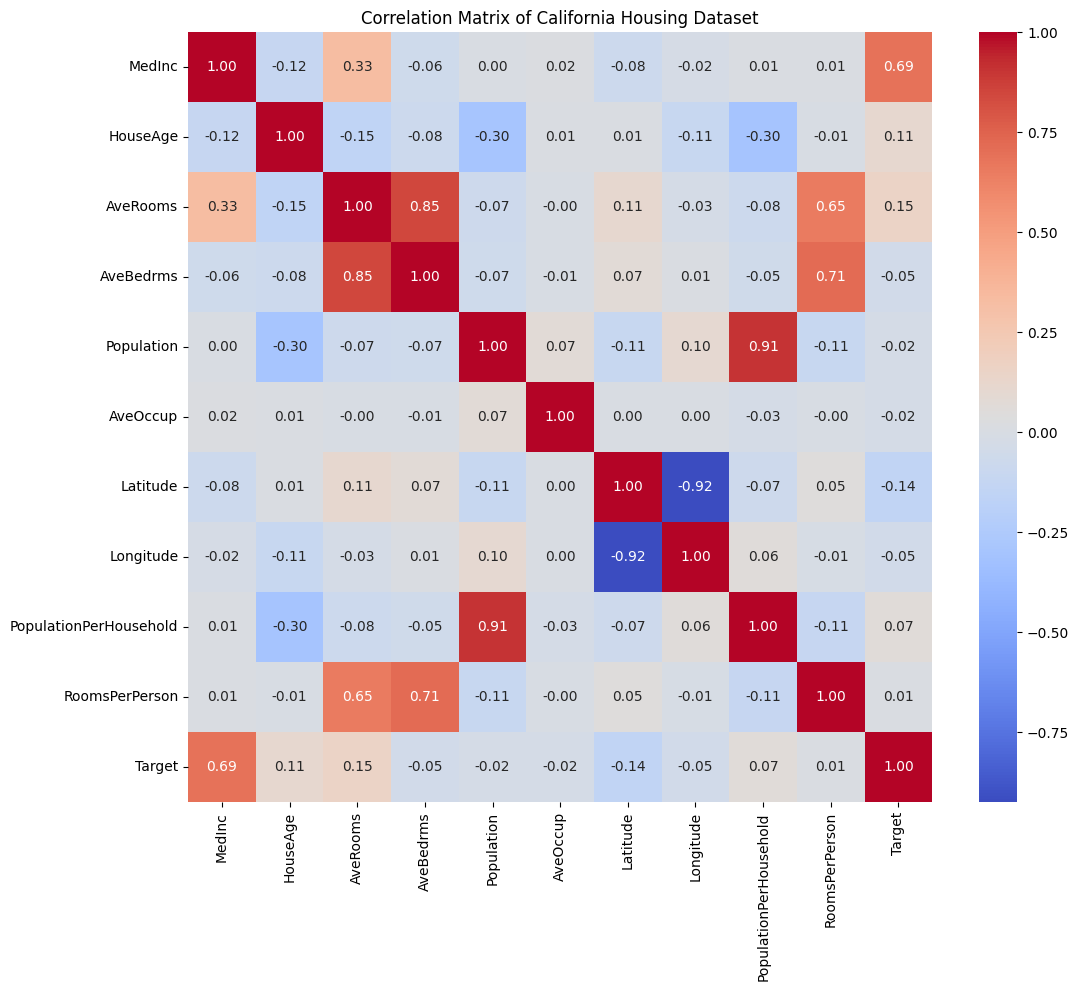

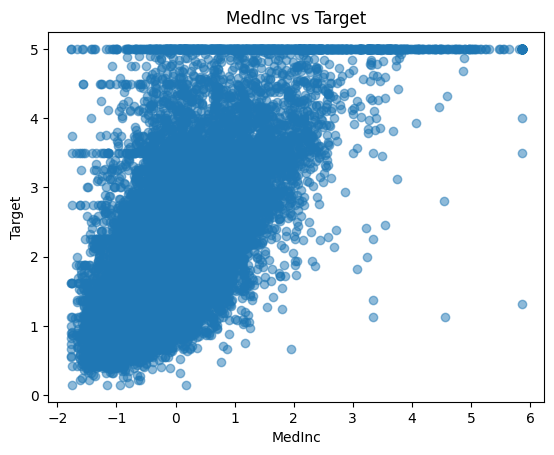

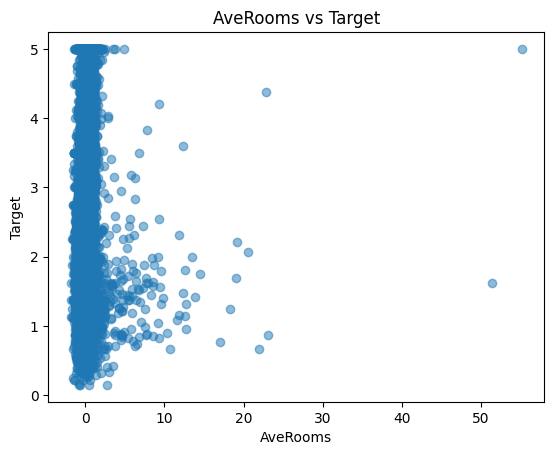

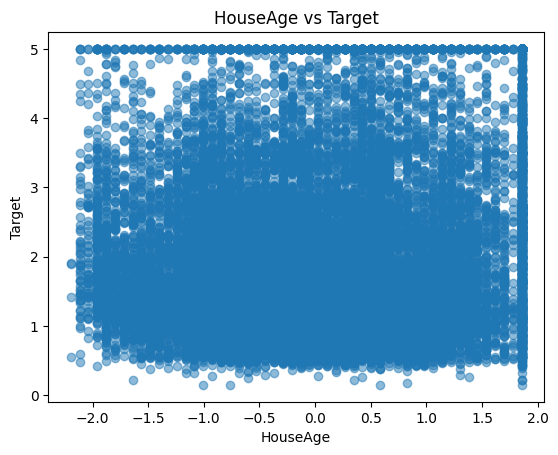

In [2]:
#PRE_PROCESSING and Visualising correlations between features and the target variable.
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Handling missing values(here there are no null values in the entire dataset(df.info()), but if there are any null values, this is how you handle it)
df.fillna(df.median(), inplace=True) #Filling all the missing values with the meadian of corresponding column. As the data is kind of like a skewed distribution, we fill in the missing values with meadian rather than deleting them or filling with 0's.

#Feature Engineering(Creating additional meaningful features(columns))
df["PopulationPerHousehold"] = df["Population"] / df["AveOccup"]
df["RoomsPerPerson"] = df["AveRooms"] / df["Population"]

# Selecting all feature columns except the target
features_to_scale = df.drop(columns=["Target"]).columns

# Scaling numerical features so that larger values do not dominate
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features_to_scale])

# Converting scaled features back into a DataFrame and add the Target column
df_scaled = pd.DataFrame(scaled_features, columns=features_to_scale)
df_scaled["Target"] = df["Target"]

# Head of the preprocessed and scaled DataFrame
print("Preprocessed DataFrame Head:")
print(df_scaled.head(), "\n")

#Correlation matrix for all the features and target.
corr_matrix = df_scaled.corr()

# Print the sorted correlation of features with the Target
corr_with_target = corr_matrix["Target"].sort_values(ascending=False)
print("Feature Correlation with Target:")
print(corr_with_target, "\n")

# Visualize the full correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of California Housing Dataset")
plt.show()

# Plot scatter-plots for the top 3 features (excluding 'Target', as we are plotting against target) most correlated with the target
features = corr_with_target.index[1:4]
for feature in features:
    plt.figure()
    plt.scatter(df_scaled[feature], df_scaled["Target"], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("Target")
    plt.title(f"{feature} vs Target")
    plt.show()

In [3]:
#Model training and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Creatinng the feature matrix (X) and target vector (y) from the preprocessed data (df_scaled)
X = df_scaled.drop(columns=["Target"])
y = df_scaled["Target"]

# Spliting the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## I'm using RandomForestRegressor Model
rf_model = RandomForestRegressor(random_state=42)

# Setting up a parameter grid for hypertuning the model
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Optimize the model using GridSearchCV(5-fold cross validation)
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Fitting GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Getting the best model from grid search
best_model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

# Predicting on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluating the model using RMSE, MAE, and R²
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Evaluation Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Saved the trained model to disk using Joblib
model_filename = "california_rf_model.joblib"
joblib.dump(best_model, model_filename)
print(f"Trained model saved as '{model_filename}'")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Evaluation Metrics:
RMSE: 0.5074
MAE: 0.3295
R²: 0.8035
Trained model saved as 'california_rf_model.joblib'


In [4]:
#Downloading the file to my system to test the model locally.
from google.colab import files
files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>